# Image Stylization

Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from PIL import Image
from os import listdir

Upload two images

In [2]:
orig_path = 'D://work//NN//Image Stylization//orig_img//'
style_path = 'D://work//NN//Image Stylization//style_img//'
result_path = 'D://work/NN//Image Stylization//result_img//'
orig_img = Image.open(orig_path + listdir(orig_path)[0])
style_img = Image.open(style_path + listdir(style_path)[0])

Visualization

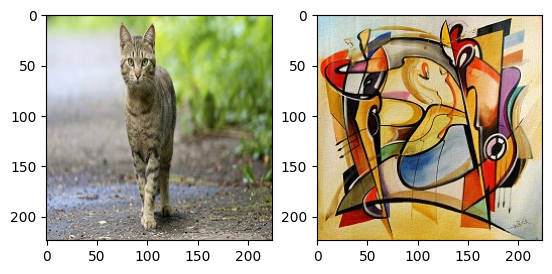

In [3]:
plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.subplot(1, 2, 2)
plt.imshow(style_img)
plt.show()

# Working with the VGG19 network.

 Network model "fa".


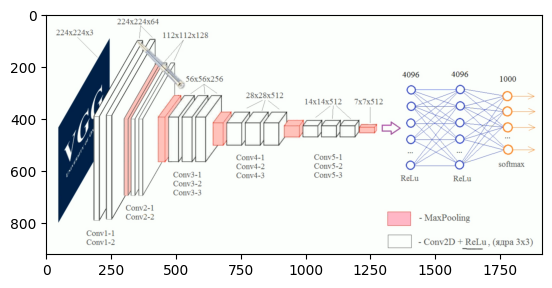

In [4]:
img_of_model = Image.open('D://work//NN//Image Stylization//network_model//model_VGG.png')
plt.imshow(img_of_model)

Convert the image to the desired format

In [5]:
# It is necessary to convert the "RGB" format to the "BGR" format.
# And let's change the average value of these components: B(-103.939), G(-116.779) and R(-123.68)
# We add one more axis to the tensor so that it looks like this: (batch, height, width, channel).
orig_img = keras.api.applications.vgg19.preprocess_input(np.expand_dims(orig_img, axis=0))
style_img = keras.api.applications.vgg19.preprocess_input(np.expand_dims(style_img, axis=0))

In [6]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0) # Remove the first axis
    assert len(x.shape) == 3,("Input of deprocess  image must be an image if " 
                              "dimension [1, height, width, channel] or [height, width, channel]")    # Checking the image dimensions
    if len(x.shape) != 3:
        raise ValueError('Invalid input of deprocess_img()')
    
    # restore average values for B, G, R
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.680
    # Swapping color components
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8') # discard everything that is not in the range of [0, 255]
    return x

In [7]:
# for  content
content_layers = ['block5_conv2']
# for style
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Loading the network VGG19.

In [8]:
# We use the network VGG19. We do not include the last fully connected layers in the network. We take the weights trained on the lib imagenet.
vgg = keras.applications.vgg19.VGG19(include_top=False,weights="imagenet") 
vgg.trainable = False # Prohibition on changing weighting factors

# Building a model based on VGG19.

In [9]:
# We take the corresponding outputs from the layers we need
style_outputs = [vgg.get_layer(name).output for name in style_layers] 
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_output = style_outputs + content_outputs
print(vgg.input)
for m in model_output:
    print(m)

model = keras.Model(vgg.input, model_output)
print(model.summary())

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, name=keras_tensor>
<KerasTensor shape=(None, None, None, 64), dtype=float32, sparse=False, name=keras_tensor_1>
<KerasTensor shape=(None, None, None, 128), dtype=float32, sparse=False, name=keras_tensor_4>
<KerasTensor shape=(None, None, None, 256), dtype=float32, sparse=False, name=keras_tensor_7>
<KerasTensor shape=(None, None, None, 512), dtype=float32, sparse=False, name=keras_tensor_12>
<KerasTensor shape=(None, None, None, 512), dtype=float32, sparse=False, name=keras_tensor_17>
<KerasTensor shape=(None, None, None, 512), dtype=float32, sparse=False, name=keras_tensor_18>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 15,304,768 (58.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [10]:
#print(vgg.summary())

In [11]:
def get_feature_representations(model):
    style_outputs = model(style_img)
    content_outputs = model(orig_img)
    
    style_features = [style_layers[0] for style_layers in style_outputs[:num_style_layers]]
    content_features = [content_layers[0] for content_layers in content_outputs[num_style_layers:]]
    return style_features, content_features

# Calculating Content Loss

In [12]:
# We get the difference between the original and the required images
def get_content_loss(base_content, target): 
    return tf.reduce_mean(tf.square(base_content - target))

#  Calculating Style Loss

In [13]:
# Calculating the Gram Matrix
def gram_matrix(input_tensor):  # input_shape = (w,h, channel)
    channels = int(input_tensor.shape[-1]) # channels = channel
    a = tf.reshape(input_tensor, [-1, channels])  # Change the tensor dimension to (w * h, channel)
    n = tf.shape(a)[0] # w * h
    gram = tf.matmul(a, a, transpose_a=True)  # gramm = G.T * G
    return gram / tf.cast(n, tf.float32) # gram = 1 / n * gram to average all values.

In [14]:
# Difference between Gram matrices for the original style and the generated image
def get_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style) # gram for base_style
    return tf.reduce_mean(tf.square(gram_style - gram_target))  #J[l]s

In [15]:
# General loss function
# model - model of nn
# loss_weights - (alpha, betta) J = Jc * a + Js * b
# init_image - target image

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights # (alpha, betta)
    
    model_outputs = model(init_image) # 5 outputs of our model
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0 # Js
    content_score= 0  # Jc
    
    weight_per_style_layer = 1.0 / float(num_style_layers) 
    
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style) # Js = wJ1 + wJ2 + wJ3... w = 1/n
        
    weight_per_content_layer = 1.0 / float(num_content_layers)
    
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer * get_content_loss(comb_content[0], target_content) # Jc = wJ1 
        
    style_score *= style_weight  # Jc * alpha
    content_score *= content_weight # Js * betta
    
    loss = style_score + content_score # J = Jc * alpha + Js * betta
    
    return loss, style_score, content_score

In [16]:
num_iterations = 100
content_weight = 0.04 
style_weight = 100

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
init_image = np.copy(orig_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

In [17]:

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=0.1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = {
    'model': model,
    'loss_weights': loss_weights,
    'init_image': init_image,
    'gram_style_features':gram_style_features,
    'content_features':content_features
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []


In [ ]:
for i in range(num_iterations):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    
    total_loss = all_loss[0]
    grads = tape.gradient(total_loss,init_image) # pixel = pixel - lmd *gradient
    
    loss, style_score, content_score = all_loss
    
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    if loss < best_loss:
        best_loss = loss
        best_img = deprocess_img(init_image.numpy())
        
        plot_img = deprocess_img(init_image.numpy())
        imgs.append(plot_img)
        print(f"Iteration{i}")
        

Iteration0
Iteration1
Iteration2


In [ ]:
plt.imshow(best_img)
print(best_loss)

In [ ]:
image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image_name = 'result.jpg'
image.save(result_path + image_name)
